In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt

#link => https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

#convert from json to strings
movies['genres'] = movies['genres'].apply(json.loads)
for index,i in zip(movies.index,movies['genres']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'genres'] = str(list1)

credits['cast'] = credits['cast'].apply(json.loads)
for index,i in zip(credits.index,credits['cast']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    credits.loc[index,'cast'] = str(list1)

credits['crew'] = credits['crew'].apply(json.loads)
def director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
credits['crew'] = credits['crew'].apply(director)
credits.rename(columns={'crew':'director'},inplace=True)

movies['keywords'] = movies['keywords'].apply(json.loads)
for index,i in zip(movies.index,movies['keywords']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'keywords'] = str(list1)

#merging movies and credits df
movies = movies.merge(credits,left_on='id',right_on='movie_id',how='left')

#selecting only important columns
movies = movies[['original_title', 'genres', 'cast', 'director', 'keywords', 'budget', 'revenue', 'vote_count', 'vote_average']]
m = movies[['original_title', 'genres', 'cast', 'director', 'keywords', 'budget', 'revenue', 'vote_count', 'vote_average']]

#rename title and rating column
movies = movies.rename(columns={'original_title': 'title', 'vote_average': 'rating'})

#remove []
movies = movies[(movies[['genres', 'cast', 'director', 'keywords']] != '[]').all(axis=1) & (movies['rating'] != 0)].dropna()

m = movies.dropna()

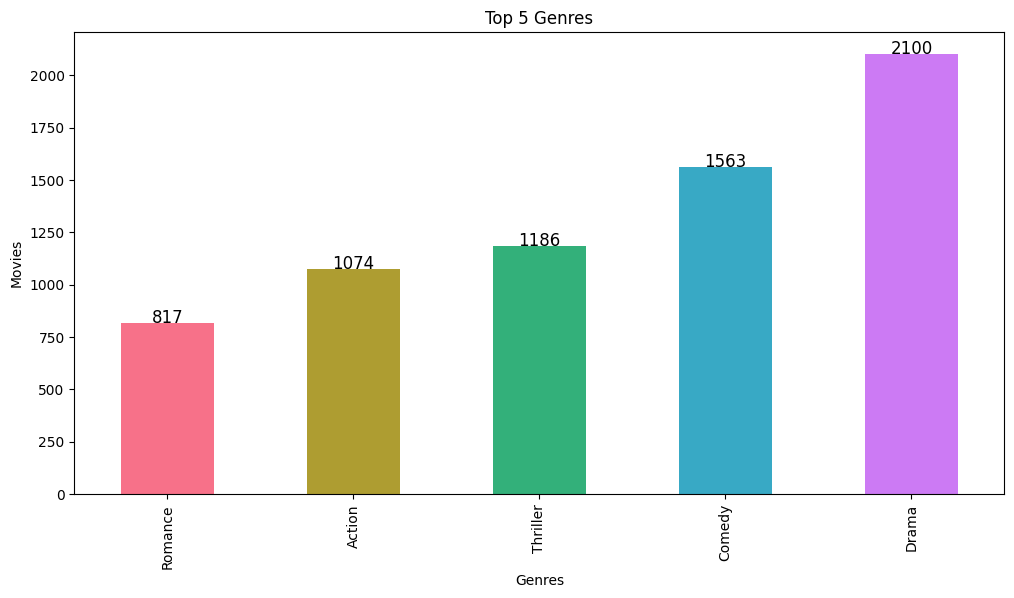

In [917]:
#Visualize
import seaborn as sns

#df for visualizations
movies_visual = movies.dropna()

#remove quotes from genres values
movies_visual['genres'] = movies_visual['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies_visual['genres'] = movies_visual['genres'].str.split(',')

#bar plot of genres
plt.subplots(figsize=(12, 6))
list1 = []

for i in movies_visual['genres']:
    list1.extend(i)

#bar colors
ax = pd.Series(list1).value_counts()[:5].sort_values().plot.bar(width=0.5, color=sns.color_palette('husl', 5))

#annotations
for i, v in enumerate(pd.Series(list1).value_counts()[:5].sort_values().values):
    ax.text(i, v + 0.1, str(v), fontsize=12, color='black', ha='center')

#labels and title
plt.xlabel('Genres')
plt.ylabel('Movies')
plt.title('Top 5 Genres')

plt.show()

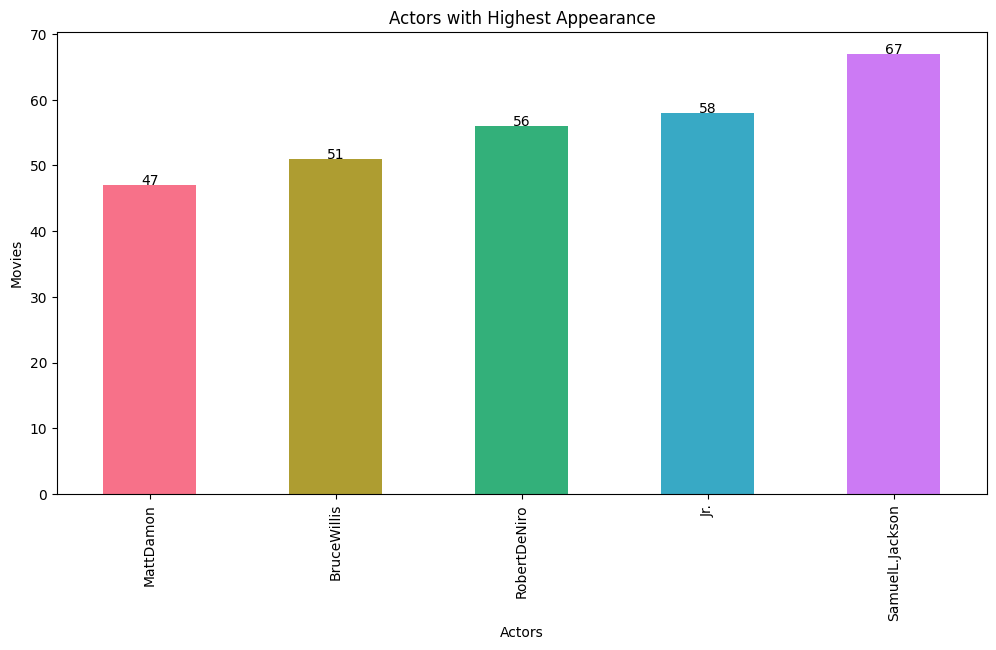

In [918]:
#remove quotes and spaces from cast
movies_visual['cast'] = movies_visual['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies_visual['cast'] = movies_visual['cast'].str.split(',')

#top actors bar chart
plt.subplots(figsize=(12, 6))
list1 = []

for i in movies_visual['cast']:
    list1.extend(i)

# Use different colors from the 'husl' color palette
ax = pd.Series(list1).value_counts()[:5].sort_values().plot.bar(width=0.5, color=sns.color_palette('husl', 5))

# Add annotations
for i, v in enumerate(pd.Series(list1).value_counts()[:5].sort_values().values):
    ax.text(i, v + 0.1, str(v), fontsize=10, color='black', ha='center')

# Set labels and title
plt.xlabel('Actors')
plt.ylabel('Movies')
plt.title('Actors with Highest Appearance')

plt.show()

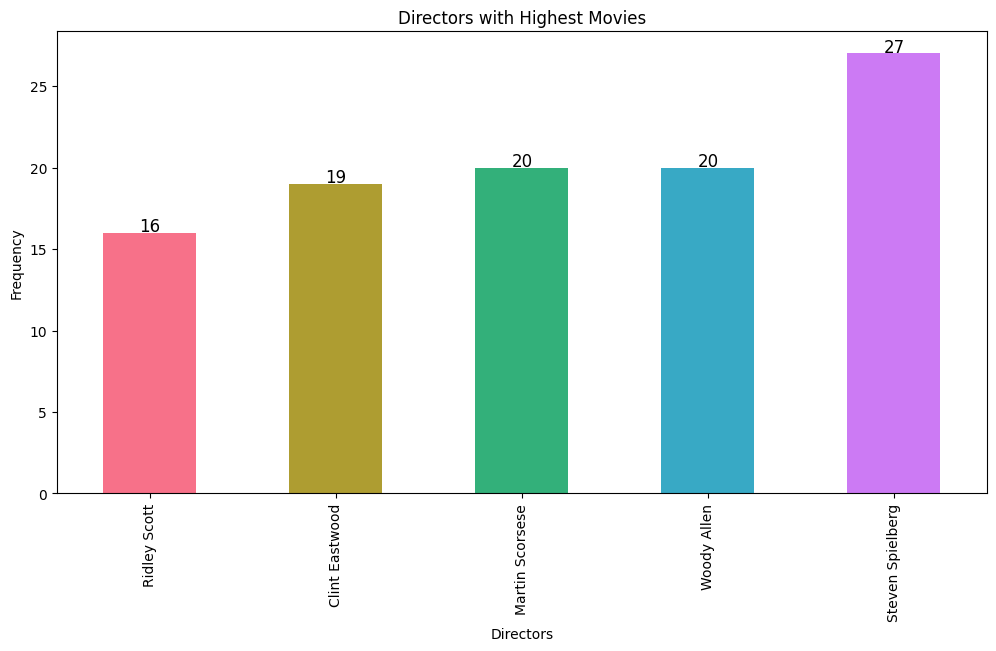

In [919]:
#directors chart
plt.subplots(figsize=(12, 6))

# Filter out rows where director is an empty string
filtered_directors = movies_visual[movies_visual['director'] != '']

ax = filtered_directors['director'].value_counts()[:5].sort_values().plot.bar(width=0.5, color=sns.color_palette('husl', 5))

# Add annotations
for i, v in enumerate(filtered_directors['director'].value_counts()[:5].sort_values().values):
    ax.text(i, v + 0.1, str(v), fontsize=12, color='black', ha='center')

# Set labels and title
plt.xlabel('Directors')
plt.ylabel('Frequency')
plt.title('Directors with Highest Movies')

plt.show()

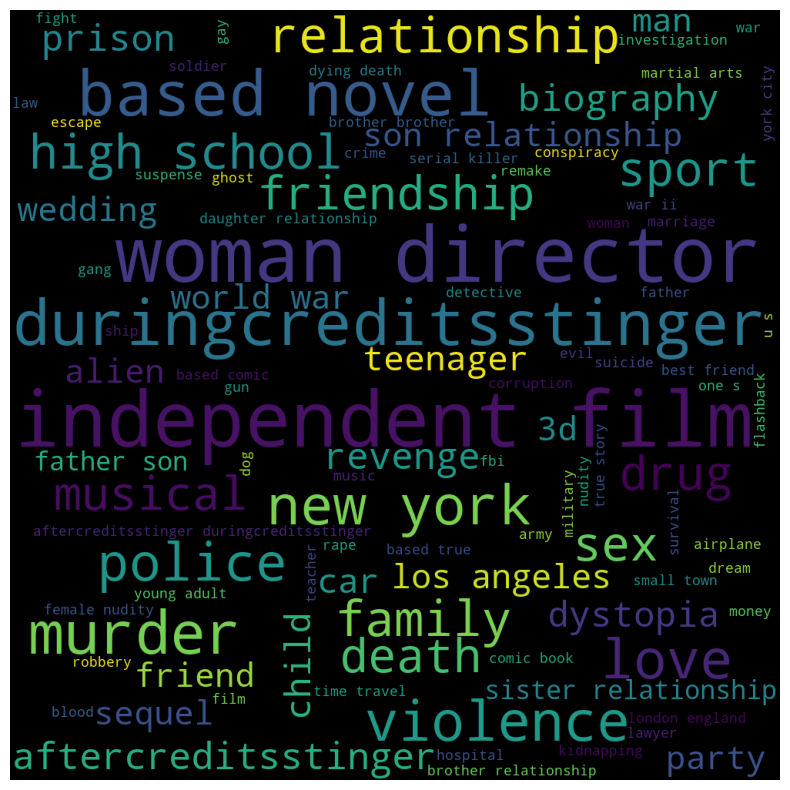

In [920]:
#plotting a word cloud

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords

plt.subplots(figsize=(12,12))
stop_words = set(stopwords.words('english'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','')

words=movies_visual['keywords'].dropna().apply(nltk.word_tokenize)

word=[]
for i in words:
    word.extend(i)
word=pd.Series(word)
word=([i for i in word.str.lower() if i not in stop_words])
wc = WordCloud(background_color="black", max_words=100, stopwords=STOPWORDS, max_font_size= 100,width=1000,height=1000)
wc.generate(" ".join(word))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

m = movies.dropna()

for col in ['genres', 'cast', 'director', 'keywords']:
    m[col] = m[col].str.strip('[]')

m = pd.get_dummies(movies, columns=['genres', 'cast', 'director', 'keywords'])

y = m['rating']
X = m.drop(columns = ['rating', 'title'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
#Kmeans clustering
from sklearn.cluster import KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataset
data_with_clusters = pd.concat([pd.DataFrame(X), pd.Series(cluster_labels, name='Cluster')], axis=1)

# Print the clusters and examine the characteristics
print(data_with_clusters.groupby('Cluster').mean())

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


               budget       revenue   vote_count  \
Cluster                                            
0.0      5.000000e+07  1.428512e+08  2443.000000   
1.0      3.377724e+07  9.654298e+07   803.246528   
2.0      2.500000e+07  4.297299e+07   973.000000   
3.0      1.847857e+07  3.784753e+07   446.857143   
4.0      6.000000e+06  2.122561e+06   392.000000   

        genres_['Action', 'Adventure', 'Animation', 'Comedy', 'Family', 'Fantasy', 'Science Fiction']  \
Cluster                                                                                                 
0.0                                                    0.0                                              
1.0                                               0.000248                                              
2.0                                                    0.0                                              
3.0                                                    0.0                                              
4.0  

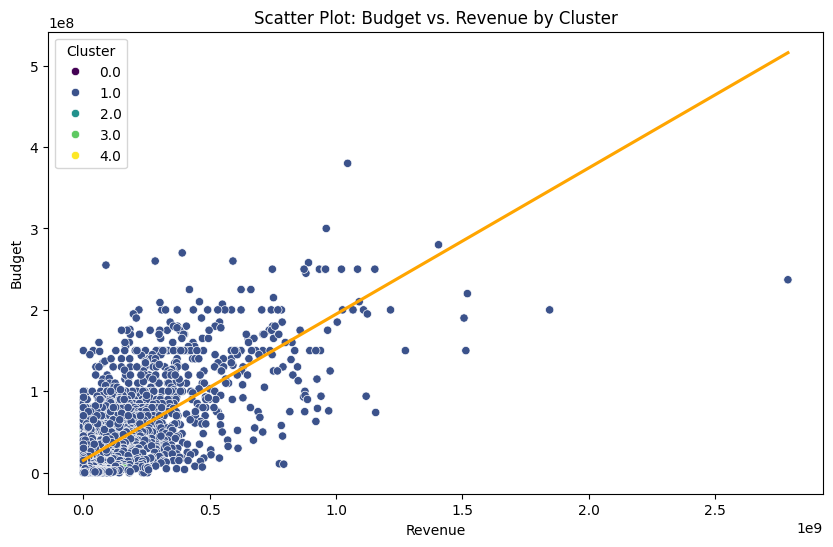

In [20]:
import seaborn as sns

# Scatter plot for budget vs. revenue colored by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x='revenue', y='budget', hue='Cluster', data=data_with_clusters, palette='viridis', hue_order=[0.0, 1.0, 2.0, 3.0, 4.0])
sns.regplot(x='revenue', y='budget', data=data_with_clusters, scatter=False, ci=None, color='orange')
plt.title('Scatter Plot: Budget vs. Revenue by Cluster')
plt.xlabel('Revenue')
plt.ylabel('Budget')
plt.show()

In [24]:
#knn model
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(X_train)

#recommend movies
def recommend_movies(x=0) :
    # Get the top 10 nearest neighbors for the movie
    distances, indices = model_knn.kneighbors(X.iloc[x, :].values.reshape(1, -1), n_neighbors = 11)
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print(f"Recommendations for {m['title'][X.index[x]]}:\n")
        else:
            print(f"{i}: {m['title'][X.index[indices.flatten()[i]]]}, with distance of {round(distances.flatten()[i], 7)}")

recommend_movies()

Recommendations for Avatar:

1: Der Untergang, with distance of 0.8842673
2: Bridesmaids, with distance of 0.9057836
3: Waterworld, with distance of 0.9102252
4: The Best Man Holiday, with distance of 0.926279
5: La grande bellezza, with distance of 0.9265693
6: Thir13en Ghosts, with distance of 0.9282426
7: Adam Resurrected, with distance of 0.9283713
8: Laws of Attraction, with distance of 0.9289903
9: Wild Wild West, with distance of 0.9301448
10: Never Let Me Go, with distance of 0.930495


In [29]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#knn
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

#rf_regressor
rf_regressor = RandomForestRegressor(n_estimators=100)
rf_regressor.fit(X_train, y_train)

#svm_regressor
svm_regressor = SVR(kernel='linear')
svm_regressor.fit(X_train, y_train)

#linear_model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

#ridge_model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

#lasso_model
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train, y_train)

#predict a movie rating
def predict_rating(i=0, model=knn, y_test = y_test):
    # Predict the response for test dataset
    y_pred = model.predict(X_test)
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    # Extract the features for the specified index
    movie_features = X_test[i, :].reshape(1, -1)
    predicted_rating = model.predict(movie_features)
    actual_rating = m['rating'][i]
    print(f"For {model}:")
    print(f"\nPredicted rating for the movie {m['title'][i]} is {predicted_rating[0]:.2f}")
    print(f"Actual Rating for the movie {m['title'][i]} is {actual_rating:.2f}")
    print(f'\nWith a mean squared error of {mse:.2f} and mean absolute error of {mae:.2f}')


In [28]:
predict_rating(model=svm_regressor)

SVR(kernel='linear')Predicted Rating for the movie Avatar is 6.04
Actual Rating for the movie Avatar is 7.20

With a Mean Squared Error of 0.77 and Mean Absolute Error of 0.67
